#### 07/30/23

#### Joshua Edelstein

# Loan Default

## Overview
background on loans, and banks offering them, and defaulting on loans

## Business Understanding
Bank XYZ is smaller end bank who has a good customer base but is struggling with loan defaults ... 
False positive(precision) predict pay back when wont vs false negative(recall) predict wont pay back when do. here precision is more important bc its worse to lose money from a loan, then to turn away a customer.

<div>
<img src="Images/inside_bank1.jpg", width = 800, height = 400/>
</div>

## Data Understanding

data source and background: https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

Let's do some EDA to find out more about are data. We'll begin by importing all the necessary packages, load our data into a pandas dataframe and preview the first 5 rows


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv('data/SBAnational.csv')

/var/folders/kl/1td686bd539f1dpck8lw65900000gn/T/ipykernel_18857/833135780.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/SBAnational.csv')


In [4]:
loan_df = df.copy()

In [4]:
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


Now let's take a look at all the columns

In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

We see that this is a very large dataframe, with around 900,000 rows and 26 columns. The column `MIS_Status` is our target column, which indicates whether the loan was paid back or not. We can also see that our dataframe has a solid amount of both int and object types. Being that many of many of the columns are in the wrong format, and have the wrong datatype we will need to perform some cleaning before we do our EDA

## Preprocessing
Let's start with the date values, which include: `ApprovalDate`, which is the date the loan was approved; `DisbursmentDate`, the date the loan was actually given; `ChgOffDate` which is the date the loan was declared in default. Let's format these properly by turning them into datetime.

In [5]:
#code from: https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer
# pandas will assume all years that are only the last 2 digits are after 2000. 
#So we need to reformat the year
def get_date(x):
    if type(x) == float:
        return None
    else:
        date = x.split('-')
        year = date[2] 
        if year == '00':
            year = '20' + year
        elif year == '20':
            year = '20' + '00'
        elif int(year) > 20:
            year = '19' + year
        else:
            year = '20' + year
        return f'{date[0]}-{date[1]}-{year}'

# Convert datetime fields into proper data type and apply get_date function
loan_df['approval_date'] = pd.to_datetime(loan_df['ApprovalDate'].apply(get_date))
loan_df['disbursement_date'] = pd.to_datetime(loan_df['DisbursementDate'].apply(get_date))
loan_df['chg_off_date'] = pd.to_datetime(loan_df['ChgOffDate'].apply(get_date))

In [6]:
#sample the new columns
print(loan_df['approval_date'].head())
print(loan_df['disbursement_date'].head())
print(loan_df['chg_off_date'].head())

0   1997-02-28
1   1997-02-28
2   1997-02-28
3   1997-02-28
4   1997-02-28
Name: approval_date, dtype: datetime64[ns]
0   1999-02-28
1   1997-05-31
2   1997-12-31
3   1997-06-30
4   1997-05-14
Name: disbursement_date, dtype: datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: chg_off_date, dtype: datetime64[ns]


All of the columns look good. Being that most of the `chg_off_date` columns are null that result also makes sense. 

For all the rows the disbursement date must be after the date the loan was approved, let's confirm if this is true

In [7]:
#create boolean values if disbursement date is later
loan_df['is_disbursement_later'] = loan_df['disbursement_date'] >= loan_df['approval_date']

#print value counts normally and as percentages
print(loan_df['is_disbursement_later'].value_counts())
print(loan_df['is_disbursement_later'].value_counts(normalize=True) * 100)

is_disbursement_later
True     895987
False      3177
Name: count, dtype: int64
is_disbursement_later
True     99.646672
False     0.353328
Name: proportion, dtype: float64


We see that there are some rows where the disbursement date was earlier. Since it's such a small percentage of the overall data, let's go ahead and drop those rows, as there may be additional input inaccuracies.

In [8]:
#drop rows with earlier disbursement date
loan_df = loan_df[loan_df['disbursement_date'] >= loan_df['approval_date']]
len(loan_df)

895987

Being that we in certain cases it may be easier to work with years for modeling, let's pull out the year from the `approved_year` column as well as the `disbursement_date` and `chg_off_date` columns.

In [9]:
# Get the year from approval_date and chg_off_date
loan_df['approved_year'] = loan_df['approval_date'].apply(lambda x: int(x.year))
loan_df['disbursement_year'] = loan_df['disbursement_date'].apply(lambda x: int(x.year))
loan_df['chg_off_year'] = loan_df['chg_off_date'].apply(lambda x: int(x.year) if not x is pd.NaT else None).astype('Int64')

Now let's drop all the columns we for sure don't need at this point.

In [13]:
loan_df = loan_df.drop(['DisbursementDate', 'ApprovalDate',
                        'ChgOffDate', 'ApprovalFY', 'is_disbursement_later'], axis=1) 

Now let's create a column to see the date and year when each of the loans were due.

In [14]:
#add the Term of the loan to the disbursement date to get the date when the loan was due
loan_df['loan_maturity_date'] = loan_df.apply(lambda x: x['disbursement_date'] + 
                                    pd.DateOffset(months = x['Term']), axis=1)
# Get loan maturity year
loan_df['loan_maturity_year'] = loan_df['loan_maturity_date'].dt.year.astype('Int64')

Since the dataset only goes till 2014, all loans that are due beyond 2014 will appear to be paid back eventhough they really have not been tracked. As such we will drop all those that extend beyond 2014, except for the ones that have already defaulted.

In [15]:
#calculate length of loan_df before the drop
original_length = len(loan_df)
#drop loans that status is Paid in Full yet extend beyond 2014
loan_df = loan_df.drop(loan_df[(loan_df['MIS_Status'] == 'P I F') & (loan_df['loan_maturity_year'] > 2014)].index)

# Loans that have no default status and extend beyond 2014 will also be dropped.
loan_df = loan_df.drop(loan_df[(loan_df['MIS_Status'].isnull()) & (loan_df['loan_maturity_year'] > 2014)].index) #242 dicarded
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,disbursement_year,chg_off_year,loan_maturity_date,loan_maturity_year
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,...,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,NaT,1997,1999,<NA>,2006-02-28,2006
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,...,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,NaT,1997,1997,<NA>,2002-05-31,2002
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,...,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,NaT,1997,1997,<NA>,2012-12-31,2012
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,...,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2002-06-30,2002
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,...,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2007-06-30,2007


In [16]:
print(f'We dropped: {original_length - len(loan_df)} rows')
print(f'Our new loan_df shape is {loan_df.shape}')

We dropped: 197957 rows
Our new loan_df shape is (698030, 31)


Now let's check out what other columns need to be cleaned.

In [17]:
loan_df.isna().sum()

LoanNr_ChkDgt              0
Name                      12
City                      30
State                     13
Zip                        0
Bank                    1458
BankState               1465
NAICS                      0
Term                       0
NoEmp                      0
NewExist                  40
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr               3344
LowDoc                  1482
DisbursementGross          0
BalanceGross               0
MIS_Status              1561
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
approval_date              0
disbursement_date          0
chg_off_date          536030
approved_year              0
disbursement_year          0
chg_off_year          536030
loan_maturity_date         0
loan_maturity_year         0
dtype: int64

The count of missing values in `chg_off_date` and `chg_off_year` probably have NaN values in all the rows that didn't default on their loans as such let's put a filler value into those rows for the EDA and drop those columns for modeling. Let's drop all the other rows that contain null values being that they make up such a small percentage of our data.

In [22]:
#drop null in all
loan_df = loan_df.dropna(subset=['MIS_Status', 'LowDoc', 'RevLineCr', 
                                 'BankState', 'Bank', 'Name', 'City', 'State', 'NewExist'])
loan_df.isna().sum()

LoanNr_ChkDgt              0
Name                       0
City                       0
State                      0
Zip                        0
Bank                       0
BankState                  0
NAICS                      0
Term                       0
NoEmp                      0
NewExist                   0
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr                  0
LowDoc                     0
DisbursementGross          0
BalanceGross               0
MIS_Status                 0
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
approval_date              0
disbursement_date          0
chg_off_date          529498
approved_year              0
disbursement_year          0
chg_off_year          529498
loan_maturity_date         0
loan_maturity_year         0
dtype: int64

Now that there are no NaN values in our loan_df, the next step is to look through all the columns and make sure that they are ready for modeling. First, we will make sure that they are the right data type. Then we will make sure there are no filler values in them. Finally, we will decide if there is a better way to group the data. After looking through all the data we have made a plan of what needs to be done, that I will map out:

Note: that for all of these columns, I seperately pulled up the value counts so none of it is in this notebook.
   - Being that the `LoanNr_ChkDgt` column is the id, we will need to change that to object type. 
   -  Being that `City` and `Zip` contain over 28,000 values with no great way to combine them, we will keep these columns for EDA and then drop them for the modeling. We will need to change the datatype on `Zip` to a string.
   - `State` needs to be broken into dummy rows for the modeling.
   - `Bank` has 5440 different values, we will regroup this column into a few columns based on value counts, and later one hot encode the column for modeling. 
       - If there are more than 10000 value counts(vcs) of a certain bank we will say the bank is Huge(12 counts)
        - If more than 1000 vcs then very_large(58 counts),
        - If more than 100 we'll say large(~500).
        - If more than 25 then small(~1000),
        - If more than 5 then very_small(~1600),
        - Below 5(~2200) then tiny.
   - `BankState`, has 5 states that appear less than 1000 times, so we will combine them as `other`. Later we will OHE the column for modeling.
   - `NAICS` is a classification code for the business so this will also be changed to object. Additionally only the first 2 digits are important. Of which certain values mean the same thing. So we also need to create a dictionary to rename the values. Later we will get dummy columns for the whole column.
   - `Term` which is the loan length will remain the same.
   - `NoEmp` which describes the number of employees will remain the same.
   - `NewExist` contains only 1s and 2s whether the business is existing or new. So we'll rename the column `Existing`, and change this to a boolean value, all values that are not 1 or 2 we will drop those rows(only 702 rows).
   - `CreateJob` and `RetainJob` give information about the number of jobs created and retained, these will remain the same.
   - `FranchiseCode` contains the franchise codes, the codes 00000 and 00001 means that its not a franchise. Being that the vast majority of the values are not a franchise, we will convert this column to a boolean if it's a franchise.
   - `UrbanRural` contains a 0,1 or 2 if its undefined, urban or rural. We will rename the values based on its true meaning, then we will fill the undefined values based on zipcode using a csv of urban rural codes per zipcode.
   - `RevLineCr` states whether the business has a revolving line of credit, the values are str Y or N. We will switch these to boolean values, and try to find the best way to fill the other values
   - `LowDoc` says whether the loan was from the LowDoc Loan Program. This program is a specific loan program that was offered by the Small Business Administration in the United States. It was designed to streamline the loan application process for small businesses by requiring less documentation compared to traditional loan programs. This column also contains Y and N, as such we will switch it to boolean values. We will drop all rows that are not Y or N(around 1500 rows).
   - `MIS_Status` is our target column whether the loan was paid in full or defaulted, as such we will rename the column `Paid` and then change it to boolean values.
   - The last 5 columns all contain monetary amounts with dollar signs, commas, and periods, as such they are stored as a str. We will reformat them as int values.
   - `DisbursementGross` contains the amount given.
   - `BalanceGross` contains the gross amount that is still due.
   - `ChgOffPrinGr` represents the amount of debt that the lender considers unlikely to be fully repaid and removes it from their active accounts receivable. 
   - `GrAppv` column indicates the gross amount of money that a bank or lending institution has approved to lend to a borrower. 
   - `SBA_Appv` column indicates the specific amount that the Small Business Administration guarantees to pay back, should the borrower not.

For the first step in out cleaning let's change all the columns that are need to be stored as strings into strings. This includes the `LoanNr_ChkDgt`, and `NAICS` column.

In [103]:
#make a list of columns to change data type
cols = ['LoanNr_ChkDgt', 'NAICS', 'Zip']

#create a for loop to change the dtypes of each to string
for col in cols:
    loan_df[col] = loan_df[col].astype(str)

#sample NAICS
loan_df.Zip.dtype

dtype('O')

Now that we have already begun the cleaning on the `NAICS` column, let's finish it up. First, we'll strip all but the first 2 numbers, as they are the only important ones. Next, we will create a dictionary to rename the values based on the general category in which they fall.

In [25]:
#ONLY RUN THIS ONCE
#pull out only the first 2 digits
loan_df['NAICS'] = loan_df['NAICS'].str.slice(stop=2)

In [26]:
#use dictionary to rename and store values together
rename_dict = {
    '0': 'Unidentified',
    '11': 'Agriculture',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale',
    '44': 'Retail',
    '45': 'Retail',
    '48': 'Transportation_Warehousing',
    '49': 'Transportation_Warehousing',
    '51': 'Information',
    '52': 'Finance_Insurance',
    '53': 'Real_Estate',
    '54': 'Professional_services',
    '55': 'Management',
    '56': 'Administration_service',
    '61': 'Education',
    '62': 'Health_care',
    '71': 'Arts',
    '72': 'Accomodation_Food',
    '81': 'Other_services',
    '92': 'Public_administration'
}

loan_df['NAICS'] = loan_df['NAICS'].replace(rename_dict)

loan_df.NAICS.value_counts()

NAICS
Unidentified                  160213
Retail                        100358
Other_services                 54754
Construction                   53286
Professional_services          52284
Manufacturing                  50790
Accomodation_Food              45081
Wholesale                      37786
Health_care                    37755
Administration_service         27404
Transportation_Warehousing     18594
Arts                           10692
Real_Estate                    10431
Information                     9440
Finance_Insurance               7178
Agriculture                     6843
Education                       4860
Mining                          1494
Utilities                        559
Public_administration            200
Management                       104
Name: count, dtype: int64

Next we will work on the `Bank` column. We will rename each value based on the amount of value counts in the dataframe. We'll break it down as we listed above.

In [29]:
# create ranges of value counts to relabel values
def map_bank(count):
    if count >= 10000:
        return 'huge'
    elif 1000 <= count < 10000:
        return 'very_large'
    elif 100 <= count < 1000:
        return 'large'
    elif 25 <= count < 100:
        return 'small'
    elif 5 <= count < 25:
        return 'very_small'
    else:
        return 'tiny'
    
# create function to apply the mapping function to desired column column
def rename_w_vcs(loan_df, column, vc_map):
    # create dictionary of value counts
    column_dict = loan_df[column].value_counts().to_dict()
    #replace bank name with value count, then replace count with new name
    loan_df[column] = loan_df[column].map(column_dict).map(vc_map)
    return loan_df

In [30]:
rename_w_vcs(loan_df, 'Bank', map_bank)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,disbursement_year,chg_off_year,loan_maturity_date,loan_maturity_year
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,very_large,OH,Retail,84,4,...,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,NaT,1997,1999,<NA>,2006-02-28,2006
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,large,IN,Accomodation_Food,60,2,...,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,NaT,1997,1997,<NA>,2002-05-31,2002
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,very_small,IN,Health_care,180,7,...,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,NaT,1997,1997,<NA>,2012-12-31,2012
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,small,OK,Unidentified,60,2,...,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2002-06-30,2002
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,very_large,DE,Manufacturing,120,19,...,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,NaT,1997,1997,<NA>,2007-06-30,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,huge,IL,Retail,60,6,...,"$70,000.00","$56,000.00",1997-02-27,1997-09-30,NaT,1997,1997,<NA>,2002-09-30,2002
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,huge,IL,Retail,60,6,...,"$85,000.00","$42,500.00",1997-02-27,1997-10-31,NaT,1997,1997,<NA>,2002-10-31,2002
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,very_large,CA,Manufacturing,108,26,...,"$300,000.00","$225,000.00",1997-02-27,1997-09-30,NaT,1997,1997,<NA>,2006-09-30,2006
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,very_large,HI,Unidentified,60,6,...,"$75,000.00","$60,000.00",1997-02-27,1997-03-31,2000-03-08,1997,1997,2000,2002-03-31,2002


In [33]:
#check that it worked
print(loan_df.Bank.value_counts())

Bank
huge          297228
very_large    181716
large         138535
small          47610
very_small     20950
tiny            4067
Name: count, dtype: int64


Great, we see that since the 12 biggest banks represented most values, they are now the largest value counts. Although there were many banks with less than 5 value counts since they appear so few times they represent a very small portion of the data. 

Now, let's replace the last few value counts in `BankState` with `other`.

In [34]:
#create dict to replace values
bankstate_dict = {'PR': 'other',
                  'GU': 'other',
                  'AN': 'other',
                  'EN': 'other',
                  'VI': 'other'}

#replace values based on dict
loan_df['BankState'] = loan_df['BankState'].replace(bankstate_dict)

#preview the results
loan_df.BankState.value_counts().tail(5)

BankState
AZ       2051
WY       1727
WV       1720
AK       1306
other     145
Name: count, dtype: int64

Now let's create a new column that is a boolean if the business recieving the loan is a francise, and we will drop the old column.

In [ ]:
#change the 1 to a 0 and keep the 0 as 0. Change all other values to a 1. Rename the column
loan_df['is_franchise'] = loan_df['FranchiseCode'].apply(lambda x: 0 if x in (0,1) else 1)

#Drop the old row
loan_df.drop(columns='FranchiseCode', axis=1, inplace=True)

#confirm it worked
loan_df.is_franchise.value_counts()

Now we will move on to check out our other columns that should only contain 2 values. This includes: `NewExist`, `RevLineCr`, `LowDoc`,`MIS_Status`, and `UrbanRural`. In theory all these columns should contain 2 values. Let's see if this is indeed the case.

In [35]:
boolean_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural']

[loan_df[col].value_counts() for col in boolean_cols]

[NewExist
 1.0    488292
 2.0    201112
 0.0       702
 Name: count, dtype: int64,
 RevLineCr
 N    315015
 0    183988
 Y    177585
 T     13470
 R        14
 1        13
 `         9
 2         5
 C         2
 ,         1
 7         1
 .         1
 -         1
 Q         1
 Name: count, dtype: int64,
 LowDoc
 N    586215
 Y    102078
 0       611
 C       455
 S       360
 A       341
 R        46
 Name: count, dtype: int64,
 MIS_Status
 P I F     534130
 CHGOFF    155976
 Name: count, dtype: int64,
 UrbanRural
 1    357079
 0    258452
 2     74575
 Name: count, dtype: int64]

For `NewExist` and `LowDoc` the vast majority of the values are are 1 and 2 or Y and N. Since we already dropped the null values in the `MIS Status` column, all the values fall into 2 categories. Being that `RevLineCr` and `UrbanRural` have a significant amount of rows with unclear values we will have to find a way to deal with those values. For now let's create a function that take in a loan_df, column, value to store as 1, and value to store as 0, list of new column name and converts the columns into boolean values, for everthing not in that list store is as a null value

In [36]:
#create function that takes in loan_df, col name, current T, current F, and new column name
def convert_to_bool(loan_df, col_name, T_value, F_value, new_col_name):
    #use apply with lambda to replace values in each row with 0,1 or nan
    loan_df[new_col_name] = loan_df[col_name].apply(lambda x: 1 if x==T_value 
                                          else(0 if x==F_value else np.nan))

In [38]:
#create list of old_cols, new_col_names, current T values, current F values
old_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural', 'RevLineCr']
new_col_names = ['Existing', 'Rev_credit_line', 'Low_doc_loan', 'Paid', 
                 'Urban', 'Rev_credit_line']
true_values = [1.0, 'Y', 'Y', 'P I F', 1, 'Y']
false_values = [2.0, 'N', 'N', 'CHGOFF', 2, 'N']

#use zip and run a for loop with function to achieve all at once
for col_name, T_value, F_value, new_col_name in zip(old_cols, true_values, 
                                                    false_values, new_col_names):
    convert_to_bool(loan_df, col_name, T_value, F_value, new_col_name)

#preview new cols
loan_df[new_col_names].head()  

,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban,Rev_credit_line
0,0.0,0.0,1.0,1,NaN,0.0
1,0.0,0.0,1.0,1,NaN,0.0
2,1.0,0.0,0.0,1,NaN,0.0
3,1.0,0.0,1.0,1,NaN,0.0
5,1.0,0.0,0.0,1,NaN,0.0


Now let's go ahead and drop the old columns as well as the nan columns in `Existing` and `Low_doc_loan` column. 

In [40]:
#drop old columns
loan_df.drop(columns=['NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'UrbanRural'], 
        axis=1, inplace=True)

#drop nan rows in Existing and Low_doc_loan column
og_len = len(loan_df)
loan_df.dropna(subset=['Existing', 'Low_doc_loan'], inplace=True)
print(f'We dropped {og_len - len(loan_df)} rows. Our loan_df is now {len(loan_df)} rows long.')

We dropped 2510 rows. Our loan_df is now 687596 rows long.


In [41]:
#CHECKPOINT. DELETE AT THE END
fr = loan_df.copy()
# loan_df = fr.copy()

Let's now fill the missing values in `UrbanRural`. We were able to obtain a breakdown of Urban and Rural by zipcode from https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/. The data cleaning was done in in a different notebook. Let's load up the csv here.

In [158]:
#load csv as pd dataframe
urban_map = pd.read_csv('data/urban_codes.csv')
urban_map.head()

,RUCA1,Zip
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


It seems that the leading zeros in zipcode got lost in the transition. Let's fill those strings with zeros.

In [163]:
#fill the zipcode column with leading zeros
urban_map['Zip'] = urban_map['Zip'].astype(str).str.zfill(5)

#preview
urban_map.head()

,RUCA1,Zip
0,0,00001
1,0,00002
2,0,00003
3,0,00004
4,0,00005


Now we will join the two dataframes together on the `Zip` column. We want to include all the rows from the `loan_df`, and only the corresponding rows from the `urban_map` loan_df. As such we will do a left join.

In [164]:
#now lets merge the dataframes with a left merge
loan_df = loan_df.merge(urban_map, on='Zip', how='left')
loan_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,disbursement_year,chg_off_year,loan_maturity_date,loan_maturity_year,Existing,Rev_credit_line,Low_doc_loan,Paid,Urban,RUCA1
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,very_large,OH,Retail,84,4,...,1999,<NA>,2006-02-28,2006,0.0,0.0,1.0,1,NaN,1.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,large,IN,Accomodation_Food,60,2,...,1997,<NA>,2002-05-31,2002,0.0,0.0,1.0,1,NaN,1.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,very_small,IN,Health_care,180,7,...,1997,<NA>,2012-12-31,2012,1.0,0.0,0.0,1,NaN,1.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,small,OK,Unidentified,60,2,...,1997,<NA>,2002-06-30,2002,1.0,0.0,1.0,1,NaN,1.0
4,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,very_large,DE,Manufacturing,120,19,...,1997,<NA>,2007-06-30,2007,1.0,0.0,0.0,1,NaN,NaN


Now let's fill the `Urban` column with the corresponding value in the `RUCA1` column, which represents whether the zip code is Urban.

In [165]:
#fill Urban col with RUCA1 values
loan_df['Urban'].fillna(loan_df['RUCA1'], inplace=True)

#drop the RUCA1 column
loan_df.drop('RUCA1', axis=1, inplace=True)

#preview results
loan_df.Urban.value_counts(dropna=False)

Urban
1.0    569029
0.0     84408
NaN     34159
Name: count, dtype: int64

We just went from 256940 null values to only 34159! 
Now we have to decide what we want to do with the rest of these null values. As well as the null values from the `Rev_credit_line` column. Let's pull up the percentages for each and then decide how to handle them.

In [166]:
#set value counts as percentage
urban_counts = loan_df.Urban.value_counts(dropna=False, normalize=True)
rev_counts = loan_df.Rev_credit_line.value_counts(dropna=False, normalize=True)

#print percent null counts
print('Urban null percentage : ', round(urban_counts.get(np.nan) * 100, 2))
print('Revolving credit line null percentage : ', round(rev_counts.get(np.nan) * 100, 2))

Urban null percentage :  4.97
Revolving credit line null percentage :  28.66


Since we have such a large dataframe and the null counts in the `Urban` column represent such a small percentage of the data lets drop those rows

In [167]:
#drop null values in Urban column
loan_df.dropna(subset=['Urban'], inplace=True)

#preview null values in column
loan_df.Urban.isna().sum()

0

Before we finish dealing with `Rev_credit_line` let's quickly clean the last few columns in our loan_df. All of the columns: `DisbursementGross`, `BalanceGross`, `ChgOffPrinGr`, `GrAppv`, and `SBA_Appv`, are number amounts but stored as a string with a dollar sign, commas and periods. As such we will strip all the punctuation and store it as a int.

In [168]:
#columns to convert
strip_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv','SBA_Appv']

#remove all punctuation that isn't a period, and store it as float
for col in strip_columns:
    loan_df[col] = loan_df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)
    
#preview results
loan_df['DisbursementGross'].head()

0     60000.0
1     40000.0
2    287000.0
3     35000.0
6     45000.0
Name: DisbursementGross, dtype: float64

In terms of dealing with the null values in `Rev_credit_line` let't try out a few different methods and run a very basic model to see how it does. First, we should do some EDA on the column to see if anything stands out. Maybe we can fill the null values in `Rev_credit_line` based on values in a different column that it highly correlates with. First lets pull up the null count again.

In [169]:
#drop str columns
test_loan_df = loan_df.drop(columns=['LoanNr_ChkDgt','City', 'Zip', 'Name', 'State', 
                                     'BankState', 'NAICS', 'Bank'], axis=1)
#pull up correlations
test_loan_df.corr()['Rev_credit_line']

Term                 -0.340619
NoEmp                -0.042183
CreateJob            -0.026631
RetainedJob          -0.021276
FranchiseCode        -0.082544
DisbursementGross    -0.140091
BalanceGross          0.003143
ChgOffPrinGr         -0.052474
GrAppv               -0.268411
SBA_Appv             -0.310511
approval_date         0.518874
disbursement_date     0.522657
chg_off_date          0.102405
approved_year         0.518141
disbursement_year     0.521407
chg_off_year          0.273301
loan_maturity_date    0.322861
loan_maturity_year    0.320645
Existing              0.119675
Rev_credit_line       1.000000
Low_doc_loan         -0.266876
Paid                 -0.098607
Urban                -0.041138
Name: Rev_credit_line, dtype: float64

We see that there is a somewhat strong correlation between `approved year` and `Rev_credit_line`, let's graph this

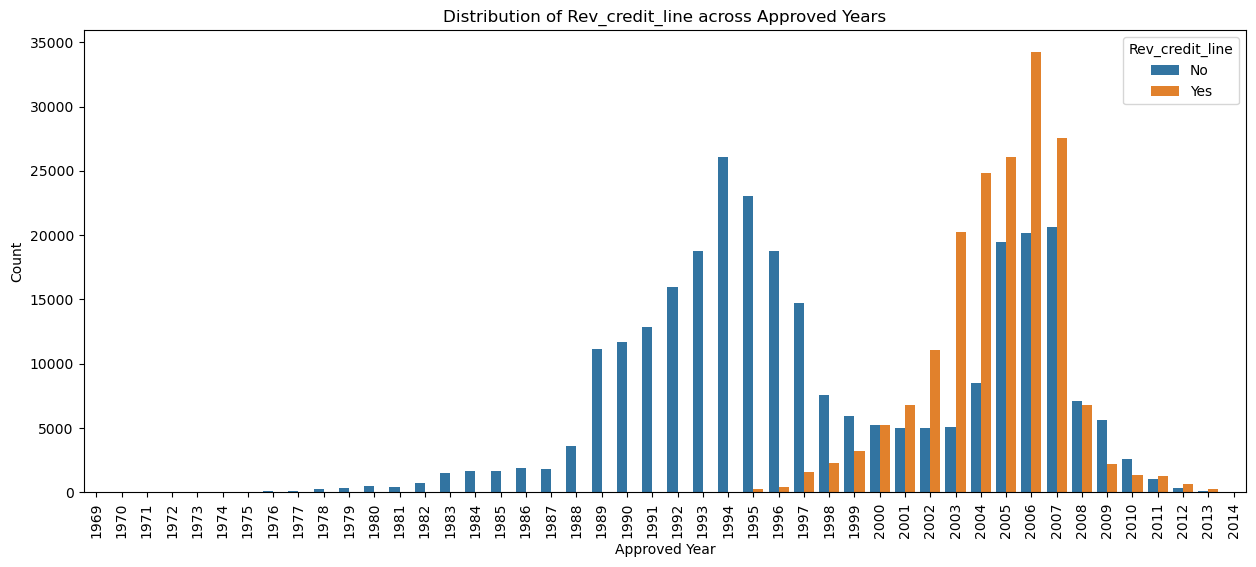

In [170]:
#set wide figure size
plt.figure(figsize=(15, 6))  # Set a wider figure size (width, height)

#create a countplot
sns.countplot(x='approved_year', hue='Rev_credit_line', data=test_loan_df)

#plot labels
plt.xlabel('Approved Year')
plt.ylabel('Count')
plt.title('Distribution of Rev_credit_line across Approved Years')
plt.legend(title='Rev_credit_line', labels=['No', 'Yes'])

#rotate ticks to vertical so the values can be seen
plt.xticks(rotation=90); 

In [171]:
# show Rev_credit_line by year
grouped_data = test_loan_df.groupby('approved_year')['Rev_credit_line'].mean()

pd.set_option('display.max_rows', None)
grouped_data

approved_year
1969    0.000000
1970    0.000000
1971    0.000000
1972    0.000000
1973    0.000000
1974    0.000000
1975    0.000000
1976    0.000000
1977    0.000000
1978    0.000000
1979    0.000000
1980    0.013274
1981    0.000000
1982    0.000000
1983    0.007208
1984    0.003041
1985    0.003005
1986    0.000000
1987    0.000000
1988    0.000000
1989    0.000000
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.001151
1995    0.009364
1996    0.022231
1997    0.097643
1998    0.227407
1999    0.349436
2000    0.500961
2001    0.574626
2002    0.688506
2003    0.800443
2004    0.744424
2005    0.572552
2006    0.629030
2007    0.571565
2008    0.489768
2009    0.279395
2010    0.337116
2011    0.543922
2012    0.663690
2013    0.655263
2014    0.277778
Name: Rev_credit_line, dtype: float64

In [172]:
#reset so it doesnt print all
pd.reset_option('display.max_rows')

Being that before the year 1994 there were almost no loans with a Revolving credit line, let's set all the null values before 1994 to 0.

In [173]:
#fill null in approved year before 1994 with 0
loan_df.loc[loan_df['approved_year'] < 1994, 'Rev_credit_line'].fillna(0, inplace=True)

loan_df.Rev_credit_line.isna().sum()

190455

This removed almost no null counts! Let's see the null counts by year to see why that is so.

In [174]:
loan_df.groupby('approved_year')['Rev_credit_line'].apply(lambda x: x.isna().sum())

approved_year
1969        0
1970        0
1971        0
1972        0
1973        0
1974        0
1975        0
1976        0
1977        0
1978        0
1979        0
1980        0
1981        0
1982        0
1983        0
1984        0
1985        0
1986        0
1987        0
1988        0
1989        0
1990        0
1991        0
1992        0
1993        1
1994        5
1995     2180
1996     6372
1997     7473
1998    12578
1999    16292
2000    16366
2001    16763
2002    20169
2003    25946
2004    26929
2005    16411
2006    12060
2007     7476
2008     3053
2009      264
2010       60
2011       33
2012       18
2013        6
2014        0
Name: Rev_credit_line, dtype: int64

We see that there was only 1 null count that occured before 1994. It clearly doesn't make sense to fill all the null counts with 0 eventhough it is the overall mode, as all the null counts were at a time where there was a higher ratio of 1s in that column. There even seems that there is a correlation between the null counts and the years that Rev_credit_line had a lot of yes values. Let's fill all the null values with 1 and run our first basic model. We'll also try creating dummy columns with the null counts to see how that does. Next, lets drop all the rows with null counts in the `Rev_credit_line` column and see how that does. Finally, we will drop the whole column to see if the model does better without it.

In [175]:
#drop all string or datetime columns
fill_1_loan_df = loan_df.drop(columns=['LoanNr_ChkDgt','City', 'Zip', 'Name',
                                       'approval_date', 'disbursement_date',
                                       'chg_off_date', 'chg_off_year',
                                       'loan_maturity_date', 'State', 
                                       'BankState', 'Bank', 'NAICS'], axis=1)

#create second practice loan_df
dummy_loan_df = fill_1_loan_df.copy()

#create third practice df
drop_loan_df = fill_1_loan_df.copy()

#drop column
drop_col_loan_df = fill_1_loan_df.copy()

In [176]:
# Method 1: fill all null values with 1
fill_1_loan_df.fillna(1, inplace=True)

In [177]:
#create a function to make dummy cols
def dummy_cols_and_drop(df, column, new_drop_dummy_value):
    #create dummy columns
    encoded_cols = pd.get_dummies(df[column], prefix=column)
    
    #drop the unidentified column
    encoded_cols.drop(f'{column}_{new_drop_dummy_value}', axis=1, inplace=True)
    
    #Switch the values from T and F to 1 and 0
    encoded_cols = encoded_cols.astype(int)
    
    #concatenate new dummy loan_df with old loan_df.
    df = pd.concat([df.drop(column, axis=1), encoded_cols], axis=1)
    
    return df

In [178]:
# method 2: create dummy columns for 1, 0 and missing
#fill null with the string 'missing'
dummy_loan_df.fillna('missing', inplace=True)

#use function from early to create dummy values
dummy_loan_df = dummy_cols_and_drop(dummy_loan_df, 'Rev_credit_line', 'missing')

#method 3: dropna values 
drop_loan_df.dropna(inplace=True)

#method 4: drop rev column
drop_col_loan_df.drop(columns='Rev_credit_line', axis=1, inplace=True)

In [179]:
#create function to test performance
def run_dt(loan_df):
    #Set X and y
    X = loan_df.drop(columns=['Paid'])
    y = loan_df['Paid']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    return print("F1 score:", f1)

In [180]:
#create loan_df list
loan_df_list = [fill_1_loan_df, dummy_loan_df, drop_loan_df, drop_col_loan_df]

#run function on both loan_df
for trial in loan_df_list:
    run_dt(trial)

F1 score: 0.9904209316328206
F1 score: 0.9904263365311892
F1 score: 0.9907293912112376
F1 score: 0.9905345821182232


Eventhough we haven't gotten to modeling, it is nice to see that we are doing a good job with the cleaning, given the extremely high F1 score. Being that the dropping the rows performed the best, we drop all null rows.

In [146]:
loan_df = loan_df.dropna(subset=['Rev_credit_line'])
len(loan_df)

462982

SEE THE AFFECT THIS HAS ON THE UNDERSAMPLING AND MAYBE GO WITH A DIFFERENT METHOD

Before we move on let's reset the index

In [148]:
loan_df.reset_index(drop=True, inplace=True)

DEAL with imbalance next from stuff below

## Preprocessing/ Cleaning

MAYBE add next 3 cells later

Since the cleaning where we filled the missing values with 1s worked the best, we will set these changes to our actual loan_df we will use for modeling. Then check if there are any null values left in the loan_df

In [206]:
#fill null values with 1 in Rev_credit_line column
# loan_df.Rev_credit_line.fillna(1, inplace=True)

In [207]:
#check null count on loan_df
# loan_df.isna().sum().sum()

0

Perfect! Now that our data is clean let's check out our target column, `Paid`.

In [208]:
#preview Paid vc
print(loan_df.Paid.value_counts())
print(loan_df.Paid.value_counts(normalize=True))

Paid
1    500865
0    152583
Name: count, dtype: int64
Paid
1    0.766496
0    0.233504
Name: proportion, dtype: float64


We see that our dataset is slightly imbalanced, let's discuss a few different ways we can handle this. Being that we have a dataset with around 650 thousand rows and around 150 columns, it wouldnt be a good idea to use SMOTE on sauch a large dataset. Especially being that in this case the imbalance isn't that strong. it try to undersample the 1s and oversample the 0s, to see if that can improve our metrics. We will then run a basic decision tree model to see how it did. Instead, let's try using weights to see if that improves the f1 score as well as undersampling the target columns that paid back their loans.

First let's try using weights

In [209]:
#checkpoint. Delete at the end
tester = loan_df.copy()

In [210]:
#drop columns that won't be used for model
tester = tester.drop(columns=['Zip', 'City', 'LoanNr_ChkDgt',
                           'approval_date', 'disbursement_date', 'chg_off_date',
                           'loan_maturity_date', 'Name'], axis=1)

In [211]:
#confirm that loan_df looks good
tester.info()

<class 'pandas.core.frame.DataFrame'>
Index: 653448 entries, 0 to 687607
Columns: 144 entries, Term to Urban
dtypes: Int64(2), float64(9), int64(133)
memory usage: 724.1 MB


In [212]:
#set X and y
X = tester.drop(columns=['Paid'])
y = tester['Paid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
#create list of weights and name them to check out
weights = [None, 'balanced', {1: 1, 0: 2}, {1: 1, 0: 3}, {1: 1, 0: 5}, {1: 10, 0: 1}]
names = ['None', 'Balanced', '1 to 2', '1 to 3', '1 to 5', '10 to 1']

#set color
colors = sns.color_palette('Set2')

#Set figure size
plt.figure(figsize=(10, 8))


for n, weight in enumerate(weights):
    # Fit model with weights
    dt = DecisionTreeClassifier(class_weight=weight, random_state=42)
    model_dt = dt.fit(X_train, y_train)

    # Predict 
    y_pred = dt.predict(X_test)
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)

    #print score
    print('F1 score for {}: {}'.format(names[n], f1))
    print('-------------------------------------------------------------------------------------');

F1 score for None: 0.9910246821241585
-------------------------------------------------------------------------------------
F1 score for Balanced: 0.9907935859157316
-------------------------------------------------------------------------------------
F1 score for 1 to 2: 0.9908084020377034
-------------------------------------------------------------------------------------
F1 score for 1 to 3: 0.9907770233216675
-------------------------------------------------------------------------------------
F1 score for 1 to 5: 0.9906347347172728
-------------------------------------------------------------------------------------
F1 score for 10 to 1: 0.9905336056997659
-------------------------------------------------------------------------------------


<Figure size 1000x800 with 0 Axes>

We see that the weights had a negative affect on the model's performance. As such let's move on to undersampling.

In [218]:
y_train.value_counts()

Paid
1    400624
0    122134
Name: count, dtype: int64

In [219]:
#initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

In [220]:
#resample
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [221]:
y_resampled.value_counts()

Paid
0    122134
1    122134
Name: count, dtype: int64

In [222]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 score:", f1)

F1 score: 0.9930743902561074


This improved our model. So when we are making our model we will run a train test split on the whole dataset, then undersample the train so it's balanced. Then test are model on the original test set.

In [ ]:
loan_df.shape
#this shape does include bankstate and regular state that were ohe into 50 col each

Pre-modeling after the eda: 
- ohe columns: Bank, BankState, NAICS, State. 
- drop: .drop(columns=['Zip', 'City', 'LoanNr_ChkDgt','approval_date', 'disbursement_date', 'chg_off_date','loan_maturity_date', 'Name'], axis=1)



Now let's get dummy variables for the column as it is categorical. We'll create a function that we can re-use for this.

In [ ]:
loan_df = dummy_cols_and_drop(loan_df, 'NAICS', 'Unidentified')
loan_df = dummy_cols_and_drop(loan_df, 'Bank', 'tiny')
#create dummy columns and drop the other column
loan_df = dummy_cols_and_drop(loan_df, 'BankState', 'other')

#create dummy columns and drop the DC column
loan_df = dummy_cols_and_drop(loan_df, 'State', 'DC')


B4 modeling deal with the class imbalance, undersample the larger side, and oversample with smote the smaller side. 

Also center the yr cols with the code below

In [ ]:
# Before we move let's offset all the year columns. Let's check out when is the first year of our data and subtract that number from all the year columns. Being that we will shortlyy drop the `chg_off_date` columns, we dont need to include it

# #create list of yr cols
# year_cols = ['disbursement_year', 'loan_maturity_year', 'approved_year']

# #create empty list
# years = []

# #fill year list with min years
# for col in year_cols:
#     years.append(min(loan_df[col]))
    
# #set the min of the years as min
# min_year = min(years)

# #print the minimum year
# print(min_year)

# #offset the year columns
# for col in year_cols:
#     loan_df[col] = loan_df[col] - min_year 

# #preview cols
# loan_df.approved_year.head()